In [2]:
!pip uninstall -y pillow
!pip install pillow==10.2.0 
!pip install torch torchvision opencv-python-headless
!pip install numpy pandas matplotlib seaborn
!pip install facenet-pytorch 
#after this restart

Found existing installation: pillow 11.0.0
Uninstalling pillow-11.0.0:
  Successfully uninstalled pillow-11.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.2 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.8 MB/s et

In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from facenet_pytorch import InceptionResnetV1
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

In [ ]:
import shutil

# Replace 'dataset_folder' with the actual folder name
dir_path = "/kaggle/working/FairFace_Subset"

shutil.rmtree(dir_path, ignore_errors=True)

print(f"Deleted directory: {dir_path}")

In [8]:
# Load FairFace dataset from Hugging Face
dataset = load_dataset('HuggingFaceM4/FairFace', '0.25')

# Define dataset sizes
train_data = dataset['train']  # Full training set
val_data = dataset['validation']  # Full validation set


In [9]:
# Define storage paths in Kaggle
BASE_PATH = "/kaggle/working/FairFace_Subset"
train_path = os.path.join(BASE_PATH, "train")
val_path = os.path.join(BASE_PATH, "val")
#test_path = os.path.join(BASE_PATH, "test")

# Create directories
for path in [train_path, val_path]:
    os.makedirs(path, exist_ok=True)


In [7]:
IMG_SIZE = 160  # FaceNet input size

# Function to preprocess & save images + metadata
def preprocess_and_save(data, folder, csv_filename):
    metadata = []
    for i, sample in enumerate(data):
        img = sample["image"]
        img = img.convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        img_filename = f"{i}.jpg"
        img_path = os.path.join(folder, img_filename)
        img.save(img_path)

        metadata.append({
            "image_path": img_path,
            "age": sample["age"],
            "gender": sample["gender"],
            "race": sample["race"]
        })

    df = pd.DataFrame(metadata)
    df.to_csv(os.path.join(BASE_PATH, csv_filename), index=False)

# Save train, val, test sets
preprocess_and_save(train_data, train_path, "train.csv")
preprocess_and_save(val_data, val_path, "val.csv")
#preprocess_and_save(test_data, test_path, "test.csv")

print("Preprocessed Images & Metadata Saved in Kaggle Working Directory!")


NameError: name 'train_data' is not defined

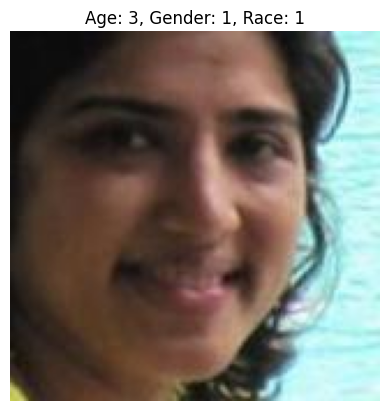

Metadata: image_path    /kaggle/working/FairFace_Subset/train/20.jpg
age                                                      3
gender                                                   1
race                                                     1
Name: 20, dtype: object


In [10]:
# Load metadata
metadata_path = os.path.join(BASE_PATH, "train.csv")
df = pd.read_csv(metadata_path)

# Display a random image
sample_idx = 20
sample_data = df.iloc[sample_idx]
image_path = sample_data["image_path"]
image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")
plt.title(f"Age: {sample_data['age']}, Gender: {sample_data['gender']}, Race: {sample_data['race']}")
plt.show()

print("Metadata:", sample_data)


In [10]:
import pandas as pd

df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
print(df.head())  # Check if "race" column exists and has valid values
print(df["race"].unique())  # See all race categories


                                    image_path  age  gender  race
0  /kaggle/working/FairFace_Subset/train/0.jpg    6       0     0
1  /kaggle/working/FairFace_Subset/train/1.jpg    4       1     1
2  /kaggle/working/FairFace_Subset/train/2.jpg    1       1     2
3  /kaggle/working/FairFace_Subset/train/3.jpg    3       1     1
4  /kaggle/working/FairFace_Subset/train/4.jpg    3       1     1
[0 1 2 3 4 5 6]


In [11]:
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))

Train set size: 86744
Validation set size: 10954


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from PIL import Image

# Load Dataset
BASE_PATH = "/kaggle/working/FairFace_Subset"  # Change path if needed
csv_path = os.path.join(BASE_PATH, "train.csv")  # Modify for test/val as needed
df = pd.read_csv(csv_path)

# Display first few rows
print("\033[1;34m Sample Dataset Preview: \033[0m")
print(tabulate(df.head(), headers="keys", tablefmt="fancy_grid"))

# Dataset Summary Table
summary_table = df.describe(include="all").transpose()
summary_table = summary_table[["count", "unique", "top", "freq"]].reset_index()
summary_table.columns = ["Feature", "Total Samples", "Unique Values", "Most Frequent Value", "Frequency"]

# Print summary table in a nice format
print("\n\033[1;32m Dataset Description: \033[0m")
print(tabulate(summary_table, headers="keys", tablefmt="fancy_grid", stralign="center"))

# Visualizing Class Distributions
plt.figure(figsize=(12, 5))
sns.countplot(x="race", data=df, palette="coolwarm", order=df["race"].value_counts().index)
plt.title("Race Distribution in FairFace Dataset", fontsize=14)
plt.xlabel("Race Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Display Sample Images from Each Race
def display_sample_images(df, num_samples=5):
    unique_races = df["race"].unique()
    fig, axes = plt.subplots(len(unique_races), num_samples, figsize=(15, len(unique_races) * 2))
    
    for i, race in enumerate(unique_races):
        race_samples = df[df["race"] == race].sample(num_samples, random_state=42)
        for j, img_path in enumerate(race_samples["image_path"]):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(race, fontsize=12, fontweight="bold")
    
    plt.suptitle("Sample Images from Each Race Category", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Call function to display images
display_sample_images(df)




In [12]:
import torchvision.transforms.functional as TF
def lighten_image(img, factor=1.8):  # Increase brightness by 20%
    return TF.adjust_brightness(img, factor)

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    #transforms.Lambda(lambda img: lighten_image(img, factor=1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class FairFaceDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform

        # Print unique race labels for debugging
        print("Unique race labels in dataset:", self.data["race"].unique())

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        race_label = str(self.data.iloc[idx]["race"]).strip().title()  # Normalize race name

        # Ensure label exists in race_classes, otherwise use -1
        # label = race_classes.get(race_label, -1)
        label = int(self.data.iloc[idx]["race"])
        # Debugging: Print race label if it's missing
        if label == -1:
            print(f"Warning: Unrecognized race label '{race_label}' at index {idx}")

        # Check if image file exists
        if not os.path.exists(img_path):
            print(f"Warning: Image not found at {img_path}. Using placeholder.")
            img = Image.new("RGB", (160, 160))  # Create a blank image
        else:
            img = Image.open(img_path).convert("RGB")
            
        if label == 4:  
            img = lighten_image(img, factor=1.8)  # Make lighter
          
        if self.transform:
            img = self.transform(img)

        return img, label

# Base Path
BASE_PATH = "/kaggle/working/FairFace_Subset"  # Change this to your actual dataset path

# Load Datasets with Transforms
train_dataset = FairFaceDataset(os.path.join(BASE_PATH, "train.csv"), transform=transform)
val_dataset = FairFaceDataset(os.path.join(BASE_PATH, "val.csv"), transform=transform)
#test_dataset = FairFaceDataset(os.path.join(BASE_PATH, "test.csv"), transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data Loaders Created Successfully!")

# Debugging: Check first batch
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"First 5 labels: {labels[:5].tolist()}")
    break

Unique race labels in dataset: [0 1 2 3 4 5 6]
Unique race labels in dataset: [0 3 5 6 2 1 4]
Data Loaders Created Successfully!
Image batch shape: torch.Size([32, 3, 160, 160])
Label batch shape: torch.Size([32])
First 5 labels: [0, 5, 4, 3, 5]


In [13]:
# Custom FaceNet Classifier 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

# Custom Model
class FaceNetClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(FaceNetClassifier, self).__init__()
        self.facenet = facenet
        # self.fc = nn.Linear(512, num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.facenet(x)  # No torch.no_grad(), so it's trainable
        return self.classifier(x)
for param in facenet.parameters():
    param.requires_grad = True  # Unfreeze all layers

# Initialize Model
model = FaceNetClassifier(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()

# # Optimizer & Learning Rate Scheduler
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
#optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)




In [42]:
# Custom ResNet-50 Classifier
import torchvision.models as models

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze early layers if needed
        for param in self.base_model.parameters():
            param.requires_grad = True  # Set False to freeze

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Initialize model
model = ResNet50Classifier(num_classes=7).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
EPOCHS = 400

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    print(f"\n🚀 Starting Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f" Processing Batch {batch_idx+1}/{len(train_loader)}")

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        print(f"🔹 Batch {batch_idx+1} | Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if batch_idx == 2:
            break
    

    acc = correct / total
    print(f"✅ Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")
    
    



🚀 Starting Epoch 1/400
 Processing Batch 1/2711
🔹 Batch 1 | Loss: 1.9579
 Processing Batch 2/2711
🔹 Batch 2 | Loss: 1.9416
 Processing Batch 3/2711
🔹 Batch 3 | Loss: 1.9525
✅ Epoch 1/400 | Loss: 5.8520, Accuracy: 0.0938

🚀 Starting Epoch 2/400
 Processing Batch 1/2711
🔹 Batch 1 | Loss: 1.9385
 Processing Batch 2/2711
🔹 Batch 2 | Loss: 1.9464
 Processing Batch 3/2711
🔹 Batch 3 | Loss: 1.9335
✅ Epoch 2/400 | Loss: 5.8185, Accuracy: 0.1354

🚀 Starting Epoch 3/400
 Processing Batch 1/2711
🔹 Batch 1 | Loss: 1.9294
 Processing Batch 2/2711
🔹 Batch 2 | Loss: 1.9390
 Processing Batch 3/2711
🔹 Batch 3 | Loss: 1.9190
✅ Epoch 3/400 | Loss: 5.7874, Accuracy: 0.2812

🚀 Starting Epoch 4/400
 Processing Batch 1/2711
🔹 Batch 1 | Loss: 1.9313
 Processing Batch 2/2711
🔹 Batch 2 | Loss: 1.9258
 Processing Batch 3/2711
🔹 Batch 3 | Loss: 1.9214
✅ Epoch 4/400 | Loss: 5.7784, Accuracy: 0.3542

🚀 Starting Epoch 5/400
 Processing Batch 1/2711
🔹 Batch 1 | Loss: 1.9102
 Processing Batch 2/2711
🔹 Batch 2 | Loss:

Test Accuracy: 0.6189

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68      1550
           1       0.66      0.59      0.62      1516
           2       0.78      0.82      0.80      1556
           3       0.59      0.78      0.67      2085
           4       0.51      0.56      0.53      1209
           5       0.49      0.35      0.41      1623
           6       0.62      0.45      0.52      1415

    accuracy                           0.62     10954
   macro avg       0.61      0.61      0.60     10954
weighted avg       0.61      0.62      0.61     10954



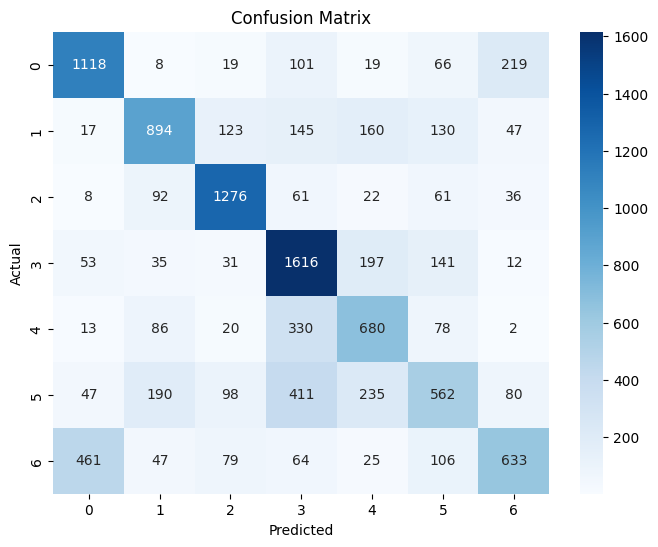

In [17]:
import seaborn as sns
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.data['race'].unique(),
            yticklabels=train_dataset.data['race'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
!pip install tabulate


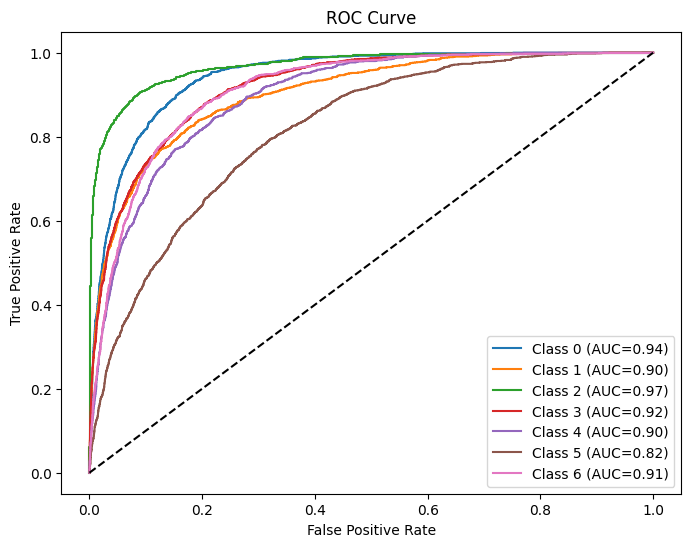


 Class-wise Metrics Table 
╒════╤═════════╤════════════╤═════════════╤══════════╤═══════════╤═══════════════╤════════╤════════╤════════╕
│    │   Class │   Accuracy │   Precision │   Recall │   F1Score │   Specificity │    FPR │    FNR │    FDR │
╞════╪═════════╪════════════╪═════════════╪══════════╪═══════════╪═══════════════╪════════╪════════╪════════╡
│  0 │  0.7213 │     0.6511 │      0.7213 │   0.6844 │    0.9363 │        0.0637 │ 0.2787 │ 0.3489 │ 0.9434 │
├────┼─────────┼────────────┼─────────────┼──────────┼───────────┼───────────────┼────────┼────────┼────────┤
│  1 │  0.5897 │     0.6612 │      0.5897 │   0.6234 │    0.9515 │        0.0485 │ 0.4103 │ 0.3388 │ 0.903  │
├────┼─────────┼────────────┼─────────────┼──────────┼───────────┼───────────────┼────────┼────────┼────────┤
│  2 │  0.8201 │     0.7752 │      0.8201 │   0.797  │    0.9606 │        0.0394 │ 0.1799 │ 0.2248 │ 0.9685 │
├────┼─────────┼────────────┼─────────────┼──────────┼───────────┼───────────────┼────────┼─

In [16]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report, 
                             matthews_corrcoef)

# Set model to evaluation mode
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        _, preds = torch.max(outputs, 1)  # Get predicted class

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Store probabilities for ROC-AUC

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
n_classes = cm.shape[0]

# Compute per-class metrics
TP = np.diag(cm)
FN = cm.sum(axis=1) - TP
FP = cm.sum(axis=0) - TP
TN = cm.sum() - (TP + FN + FP)

# Metrics per class
accuracy_per_class = TP / cm.sum(axis=1)  
precision_per_class = TP / (TP + FP + 1e-6)  
recall_per_class = TP / (TP + FN + 1e-6)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-6)
specificity_per_class = TN / (TN + FP + 1e-6)
FPR_per_class = FP / (FP + TN + 1e-6)
FNR_per_class = FN / (FN + TP + 1e-6)
FDR_per_class = FP / (FP + TP + 1e-6)

# Matthews Correlation Coefficient (Overall)
mcc = matthews_corrcoef(all_labels, all_preds)

# Compute ROC-AUC per class
auc_scores = []
plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    auc = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])
    auc_scores.append(auc)
    
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.2f})')

# ROC Curve Plot
plt.plot([0,1], [0,1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Prepare table data
table_data = []
for i in range(n_classes):
    table_data.append([
        i,
        f"{accuracy_per_class[i]:.4f}",
        f"{precision_per_class[i]:.4f}",
        f"{recall_per_class[i]:.4f}",
        f"{f1_per_class[i]:.4f}",
        f"{specificity_per_class[i]:.4f}",
        f"{FPR_per_class[i]:.4f}",
        f"{FNR_per_class[i]:.4f}",
        f"{FDR_per_class[i]:.4f}",
        f"{auc_scores[i]:.4f}"
    ])

# Print the table using tabulate
headers = ["Class", "Accuracy", "Precision", "Recall", "F1Score", "Specificity", "FPR", "FNR", "FDR"]
print("\n\033[1;34m Class-wise Metrics Table \033[0m")  # Blue title
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid", stralign="center"))

# Print overall MCC
print(f"\n\033[1;32mMatthews Correlation Coefficient (MCC): {mcc:.4f}\033[0m")  # Green MCC


<Figure size 1200x600 with 0 Axes>

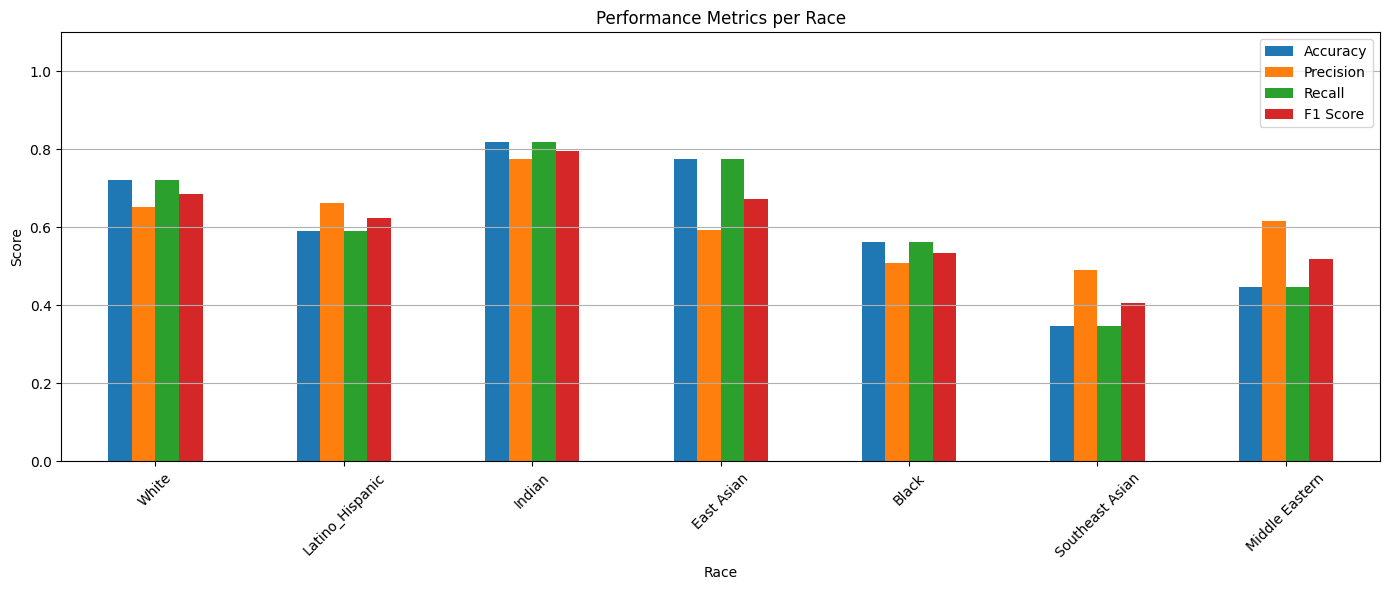

In [18]:
# Optional: Map class index to race labels (adjust this as per your class mappings)
race_labels = {
    0: "White" , 1: "Latino_Hispanic", 2: "Indian", 3: "East Asian" ,
    4: "Black", 5:"Southeast Asian" , 6: "Middle Eastern"
}
# # Race Mapping
# race_classes = {
#     'East Asian': 3, 'Indian': 2, 'Black': 4, 'White': 0, 'Middle Eastern': 6, 'Latino_Hispanic': 1,
#     'Southeast Asian': 5
# }

# Plot per-class metrics
metrics_df = pd.DataFrame({
    "Race": [race_labels[i] for i in range(n_classes)],
    "Accuracy": accuracy_per_class,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1 Score": f1_per_class,
    
})

# Plot all metrics
plt.figure(figsize=(12, 6))
metrics_df.set_index("Race").plot(kind="bar", figsize=(14, 6))
plt.title("Performance Metrics per Race")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.grid(axis="y")
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


In [28]:
model_path = "/kaggle/working/facenet_race_classifier.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Model saved at /kaggle/working/facenet_race_classifier.pth
